## Chapter 7

### Gradient Based Methods

##### We will look at the explanations provided through these methods

This notebook focusses on Gradient Based Methods like Integrated Gradients, GradientSHAP, LRP. We use the pretrained resnet18 model from torchvision.

There is a file imagenet_class_index.json which has the labels for the model <br>

Original source for this notebook is from the Captum library - https://captum.ai/tutorials/TorchVision_Interpret

**Install the required models**

In [2]:
pip install torch torchvision pillow captum

Note: you may need to restart the kernel to use updated packages.


**Import pytorch and captum required library modules**

In [3]:
import torch
import torch.nn.functional as F


from PIL import Image


import os
import json
import numpy as np
from matplotlib.colors import LinearSegmentedColormap


import torchvision
from torchvision import models
from torchvision import transforms


from captum.attr import IntegratedGradients
from captum.attr import GradientShap
from captum.attr import LRP
from captum.attr import Occlusion
from captum.attr import NoiseTunnel
from captum.attr import visualization as viz
from captum.attr._utils.lrp_rules import EpsilonRule, GammaRule, Alpha1_Beta0_Rule


**Load the pretrained resnet18 model**

In [4]:
model = models.resnet18(pretrained=True)
model = model.eval()


c:\Users\achakkirala\AppData\Local\miniconda3\envs\env-02\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\achakkirala\AppData\Local\miniconda3\envs\env-02\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


**Build the image transformation, resizing, normalizing the image**

In [7]:
transform = transforms.Compose([
 transforms.Resize(256),
 transforms.CenterCrop(224),
 transforms.ToTensor()
])


transform_normalize = transforms.Normalize(
     mean=[0.485, 0.456, 0.406],
     std=[0.229, 0.224, 0.225]
 )


img = Image.open('swan-3299528_1280.jpg')


transformed_img = transform(img)


input = transform_normalize(transformed_img)
input = input.unsqueeze(0)


**Extract the class labels for the prediction mapping**

The original labels used in the pretrained models are loaded from the json file in the same path, imagenet_class_index.json

In [9]:
labels_path = 'imagenet_class_index.json'
with open(labels_path) as json_data:
    idx_to_labels = json.load(json_data)

**Run the prediction on the transformed image and print the mapped labels**

In [10]:
output = model(input)
output = F.softmax(output, dim=1)
prediction_score, pred_label_idx = torch.topk(output, 1)


pred_label_idx.squeeze_()
predicted_label = idx_to_labels[str(pred_label_idx.item())][1]
print('Predicted:', predicted_label, '(', prediction_score.squeeze().item(), ')')


Predicted: goose ( 0.4569336771965027 )


### Integrated Gradients

**Instantiate the Integrated Gradients on the model for the input to be predicted**

In [11]:
print('Predicted:', predicted_label, '(', prediction_score.squeeze().item(), ')')


integrated_gradients = IntegratedGradients(model)
attributions_ig = integrated_gradients.attribute(input, target=pred_label_idx, n_steps=200)


Predicted: goose ( 0.4569336771965027 )


The image is identfied rightly as goose.

**Plot the output from the Integrated Gradient result as image**

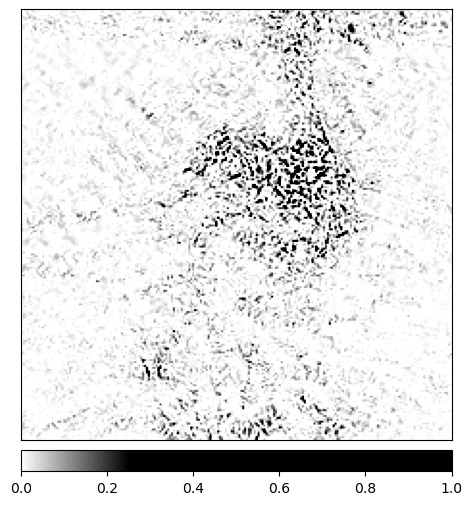

In [12]:
default_cmap = LinearSegmentedColormap.from_list('custom blue',
                                                 [(0, '#ffffff'),
                                                  (0.25, '#000000'),
                                                  (1, '#000000')], N=256)


_ = viz.visualize_image_attr(np.transpose(attributions_ig.squeeze().cpu().detach().numpy(), (1,2,0)),
                             np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                             method='heat_map',
                             cmap=default_cmap,
                             show_colorbar=True,
                             sign='positive',
                             outlier_perc=1)


#### Gradient SHAP

**Instantiate Gradient SHAP on the pretrained model and display the gradient result alonwith the original image**

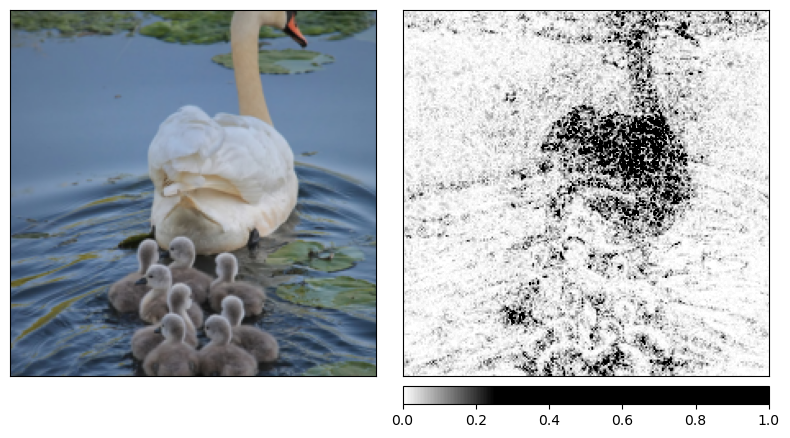

In [13]:
torch.manual_seed(0)
np.random.seed(0)


gradient_shap = GradientShap(model)


# Defining baseline distribution of images
rand_img_dist = torch.cat([input * 0, input * 1])


attributions_gs = gradient_shap.attribute(input,
                                          n_samples=50,
                                          stdevs=0.0001,
                                          baselines=rand_img_dist,
                                          target=pred_label_idx)
_ = viz.visualize_image_attr_multiple(np.transpose(attributions_gs.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map"],
                                      ["all", "absolute_value"],
                                      cmap=default_cmap,
                                      show_colorbar=True)
